# INTRODUCTION

## Goal

The goal of the problem is to predict whether a passenger was satisfied or not considering his/her overall experience of traveling on the Shinkansen Bullet Train.

## Dataset

The problem consists of 2 separate datasets: Travel data & Survey data. Travel data has information related to passengers and attributes related to the Shinkansen train, in which they traveled. The survey data is aggregated data of surveys indicating the post-service experience. You are expected to treat both these datasets as raw data and perform any necessary data cleaning/validation steps as required.

# SET UP

In [43]:
%%capture
!pip install polars

In [44]:
# data processing lib
import numpy as np
import pandas as pd
import polars as pl

# data viz lib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly import subplots

# ML lib
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [45]:
train_travel_link = "https://raw.githubusercontent.com/amrirasyidi/mit_idss_hackaton/main/data/Traveldata_train.csv"
train_survey_link = "https://raw.githubusercontent.com/amrirasyidi/mit_idss_hackaton/main/data/Surveydata_train.csv"

test_travel_link = "https://raw.githubusercontent.com/amrirasyidi/mit_idss_hackaton/main/data/Traveldata_test.csv"
test_survey_link = "https://raw.githubusercontent.com/amrirasyidi/mit_idss_hackaton/main/data/Surveydata_test.csv"

## Polars

In [46]:
train_travel = pl.read_csv(train_travel_link, infer_schema_length=0).lazy()
train_survey = pl.read_csv(train_survey_link, infer_schema_length=0).lazy()

test_travel = pl.read_csv(test_travel_link, infer_schema_length=0).lazy()
test_survey = pl.read_csv(test_survey_link, infer_schema_length=0).lazy()

In [47]:
# rename columns

COLUMN_MAPPING = {col:col.lower() for col in train_travel.columns}
train_travel = train_travel.rename(COLUMN_MAPPING)

In [48]:
train_travel = train_travel.with_column(
    pl.col([
        "id",
        "age",
        "travel_distance",
        "departure_delay_in_mins",
        "arrival_delay_in_mins",
        ]).cast(pl.Int64, strict=False)
)

In [49]:
train_travel.head().collect()

id,gender,customer_type,age,type_travel,travel_class,travel_distance,departure_delay_in_mins,arrival_delay_in_mins
i64,str,str,i64,str,str,i64,i64,i64
98800001,"""Female""","""Loyal Customer...",52,null,"""Business""",272,0,5
98800002,"""Male""","""Loyal Customer...",48,"""Personal Trave...","""Eco""",2200,9,0
98800003,"""Female""","""Loyal Customer...",43,"""Business Trave...","""Business""",1061,77,119
98800004,"""Female""","""Loyal Customer...",44,"""Business Trave...","""Business""",780,13,18
98800005,"""Female""","""Loyal Customer...",50,"""Business Trave...","""Business""",1981,0,0


## Pandas

In [50]:
train_travel = pd.read_csv(train_travel_link)
train_survey = pd.read_csv(train_survey_link)

test_travel = pd.read_csv(test_travel_link)
test_survey = pd.read_csv(test_survey_link)

In [51]:
# Overview of the travel data
train_travel.head(3)

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
0,98800001,Female,Loyal Customer,52.0,NaN,Business,272,0.0,5.0
1,98800002,Male,Loyal Customer,48.0,Personal Travel,Eco,2200,9.0,0.0
2,98800003,Female,Loyal Customer,43.0,Business Travel,Business,1061,77.0,119.0


In [52]:
# Statistics of the travel data
train_travel.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,94379.0,9.884719e+07,27245.014865,98800001.0,98823595.5,98847190.0,98870784.5,98894379.0
Age,94346.0,3.941965e+01,15.116632,7.0,27.0,40.0,51.0,85.0
Travel_Distance,94379.0,1.978888e+03,1027.961019,50.0,1359.0,1923.0,2538.0,6951.0
Departure_Delay_in_Mins,94322.0,1.464709e+01,38.138781,0.0,0.0,0.0,12.0,1592.0
Arrival_Delay_in_Mins,94022.0,1.500522e+01,38.439409,0.0,0.0,0.0,13.0,1584.0


In [53]:
# Info of the travel data
train_travel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Gender                   94302 non-null  object 
 2   Customer_Type            85428 non-null  object 
 3   Age                      94346 non-null  float64
 4   Type_Travel              85153 non-null  object 
 5   Travel_Class             94379 non-null  object 
 6   Travel_Distance          94379 non-null  int64  
 7   Departure_Delay_in_Mins  94322 non-null  float64
 8   Arrival_Delay_in_Mins    94022 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 6.5+ MB


In [54]:
# check duplicates
print("Is there any duplicate in the data? ",train_travel.duplicated().any())

Is there any duplicate in the data?  False


In [55]:
# rename columns

COLUMN_MAPPING = {col:col.lower() for col in train_travel.columns}
train_travel = train_travel.rename(columns = COLUMN_MAPPING)

In [80]:
train_survey.head(3)

,id,overall_experience,seat_comfort,seat_class,arrival_time_convenient,catering,platform_location,onboard_wifi_service,onboard_entertainment,online_support,ease_of_online_booking,onboard_service,legroom,baggage_handling,checkin_service,cleanliness,online_boarding
0,98800001,0,Needs Improvement,Green Car,Excellent,Excellent,Very Convenient,Good,Needs Improvement,Acceptable,Needs Improvement,Needs Improvement,Acceptable,Needs Improvement,Good,Needs Improvement,Poor
1,98800002,0,Poor,Ordinary,Excellent,Poor,Needs Improvement,Good,Poor,Good,Good,Excellent,Needs Improvement,Poor,Needs Improvement,Good,Good
2,98800003,1,Needs Improvement,Green Car,Needs Improvement,Needs Improvement,Needs Improvement,Needs Improvement,Good,Excellent,Excellent,Excellent,Excellent,Excellent,Good,Excellent,Excellent


In [57]:
train_survey.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,94379.0,9.884719e+07,27245.014865,98800001.0,98823595.5,98847190.0,98870784.5,98894379.0
Overall_Experience,94379.0,5.466576e-01,0.497821,0.0,0.0,1.0,1.0,1.0


In [58]:
train_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       94379 non-null  int64 
 1   Overall_Experience       94379 non-null  int64 
 2   Seat_Comfort             94318 non-null  object
 3   Seat_Class               94379 non-null  object
 4   Arrival_Time_Convenient  85449 non-null  object
 5   Catering                 85638 non-null  object
 6   Platform_Location        94349 non-null  object
 7   Onboard_Wifi_Service     94349 non-null  object
 8   Onboard_Entertainment    94361 non-null  object
 9   Online_Support           94288 non-null  object
 10  Ease_of_Online_Booking   94306 non-null  object
 11  Onboard_Service          86778 non-null  object
 12  Legroom                  94289 non-null  object
 13  Baggage_Handling         94237 non-null  object
 14  CheckIn_Service          94302 non-nul

In [79]:
# rename columns

COLUMN_MAPPING_SURVEY = {col:col.lower() for col in train_survey.columns}
train_survey = train_survey.rename(columns = COLUMN_MAPPING_SURVEY)

In [121]:
# to unify the rating, we will convert values in platform_location column

odd_val = [
    "Very Inconvenient",
    "Inconvenient",
    "Needs Improvement",
    "Manageable",
    "Convenient",
    "Very Convenient"
    ]
correct_val = [
    "Extremely Poor",
    "Poor",
    "Needs Improvement",
    "Acceptable",
    "Good",
    "Excellent"
]

VALUE_MAPPING_SURVEY = dict(zip(odd_val,correct_val))

In [123]:
train_survey['platform_location'] = train_survey['platform_location'].map(VALUE_MAPPING_SURVEY)

## Classes and Functions

In [139]:
# transforming categorical column into numerical labels
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

# visualize null count as horizontal bar plot
def null_viz(data = train_travel):
  NULL_COUNT = pd.DataFrame(data.isna().sum()).reset_index().rename(columns = {'index':'variable',0:'count'}).sort_values(by='count')
  NULL_COUNT['pct'] = (NULL_COUNT['count']/data.shape[0])

  fig, ax = plt.subplots(figsize = (15,6))

  width = .8

  bars = NULL_COUNT['count'].plot.barh(color='green', ax=ax, width=width)

  for i, v in enumerate(NULL_COUNT['pct']):
      ax.text(v + 100, i, '{:.2%}'.format(v), fontweight='bold')

  ax.set_ylabel('Variable');
  ax.set_yticklabels(data.columns);

  ax.set_xlabel('Count');

  ax.set_title("Null Value \nCount and Percentage", fontsize=20, fontweight='bold', fontfamily='monospace')

  return (fig, ax)

# visualize categorical variable distribution as horizontal bar plot
def cat_distribution(data = train_travel, nrows = 2, ncols = 2, width = 15, height = 6, order = 'count'):
  fig, ax = plt.subplots(nrows,ncols, figsize = (width,height))
  plt.suptitle("Distribution of\nCategorical Variables", fontsize=20, fontweight='bold', fontfamily='monospace', y = 1.1)

  col = data.select_dtypes(exclude=np.number).columns.tolist()

  for var,axs in zip(col, ax.flatten()):
    if order == 'count':
      order = data[var].fillna("Null").value_counts().index
    else:
      order = correct_val

    cnt = sns.countplot(
        y = data[var].fillna("Null"),
        ax = axs,
        color = 'lightblue',
        order = order
    )

    cnt.set_ylabel('')
    cnt.set_title(var, fontweight = 'bold')

  plt.tight_layout()

  return (fig, ax)

# visualize numerical variable distribution as histogram
def num_distribution(data = train_travel, nrows = 2, ncols = 2, width = 15, height = 6):
  fig, ax = plt.subplots(nrows,ncols, figsize = (width,height))
  plt.suptitle("Distribution of\nNumerical Variables", fontsize=20, fontweight='bold', fontfamily='monospace', y = 1.1)

  col = data.select_dtypes(include=np.number).columns.tolist()[1:]

  for var,axs in zip(col, ax.flatten()):
    cnt = sns.histplot(
        x = data[var],
        ax = axs,
        color = 'lightblue'
    )

    cnt.set_ylabel('')
    cnt.set_title(var, fontweight = 'bold')

  plt.tight_layout()

  return (fig, ax)

# visualize variable correlation heatmap
def corr_heatmap(data = train_travel, width = 16, height = 12):
  # https://www.kdnuggets.com/2021/04/awesome-tricks-best-practices-kaggle.html

  # Calculate pairwise-correlation
  matrix = data.corr()

  # Create a mask
  mask = np.triu(np.ones_like(matrix, dtype=bool))

  # Create a custom diverging palette
  cmap = sns.diverging_palette(250, 15, s=75, l=40,n=9, 
                              center="light", 
                              as_cmap=True
                              )

  plt.figure(figsize=(width, height))
  plt.title("Variable Correlation Heatmap", fontsize=20, fontweight='bold', fontfamily='monospace')
  sns.heatmap(matrix, mask=mask, center=0, annot=True, 
              fmt='.2f', square=True, cmap=cmap)
  
  return (fig, ax)

# EXPLORATION

## Travel

In [59]:
NULL_COUNT = pd.DataFrame(train_travel.isna().sum()).reset_index().rename(columns = {'index':'variable',0:'count'}).sort_values(by='count')
NULL_COUNT['pct'] = (NULL_COUNT['count']/train_travel.shape[0])

(<Figure size 1080x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f481fd6b1d0>)

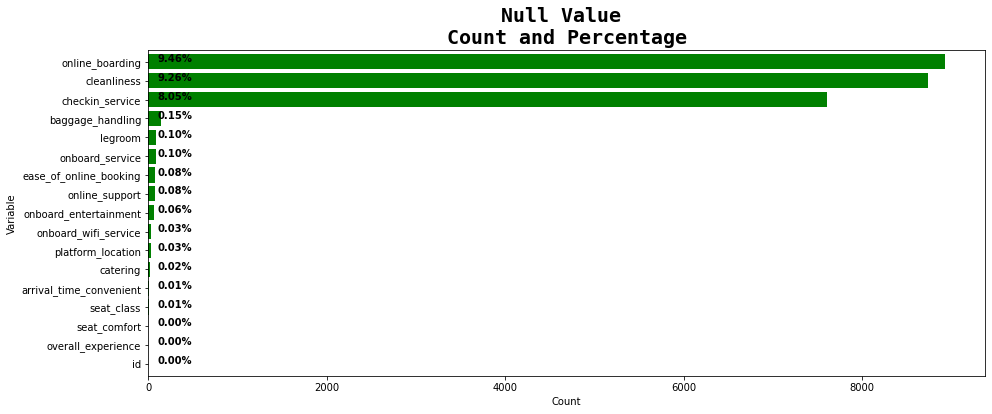

In [83]:
null_viz()

### Univariate

In [62]:
CAT_COL = train_travel.select_dtypes(exclude=np.number).columns.tolist()
NUM_COL = train_travel.select_dtypes(include=np.number).columns.tolist()[1:]

(<Figure size 1080x432 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f481c7763d0>,
       dtype=object))

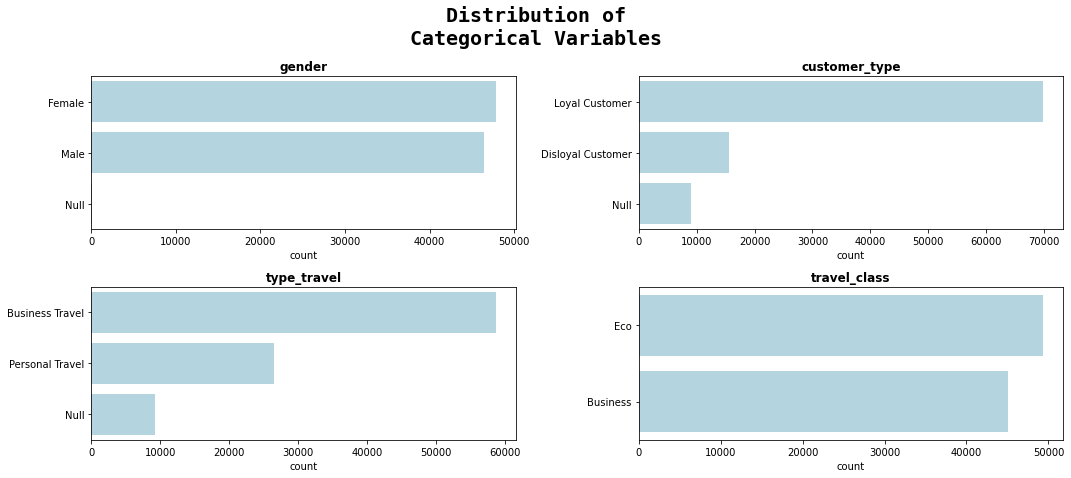

In [88]:
cat_distribution()

(<Figure size 1080x432 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f482235b0d0>,
       dtype=object))

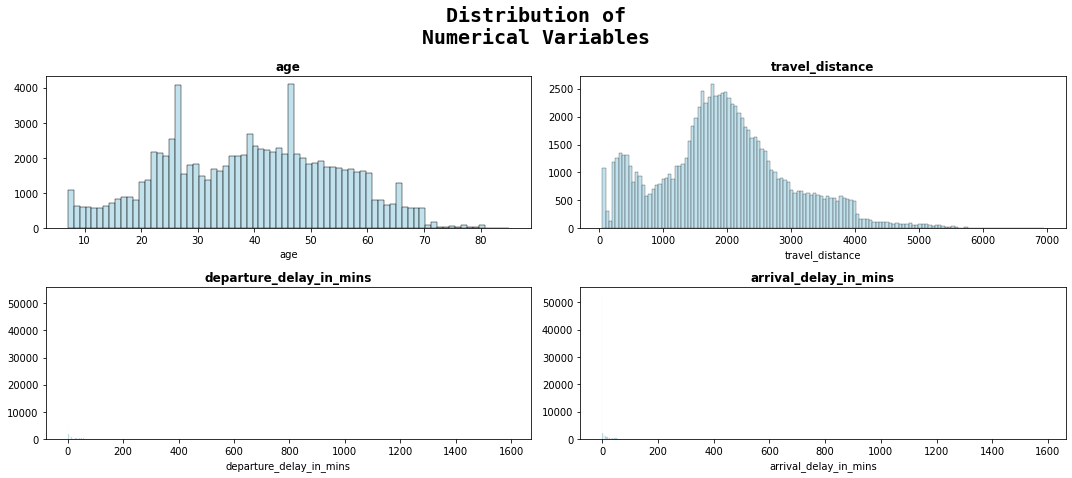

In [91]:
num_distribution()

#### Observation

- Categorical
  - Gender and travel class are relatively evenly distributed
  - Customer type and travel type are imbalanced
- Numerical
  - There are spikes in age around 26 and 46 years old passengers. Without the spike, the distribution is almost bell shaped
  - Travel distance has a bimodal distribution, around 500 and 2000 distances
  - Delay, both in departure and arrival seems to have an outliers. The distribution is very spread out as suggested by the statistics (`.describe()`)

### Multivariate

In [66]:
plot_table = train_travel.fillna("Null")

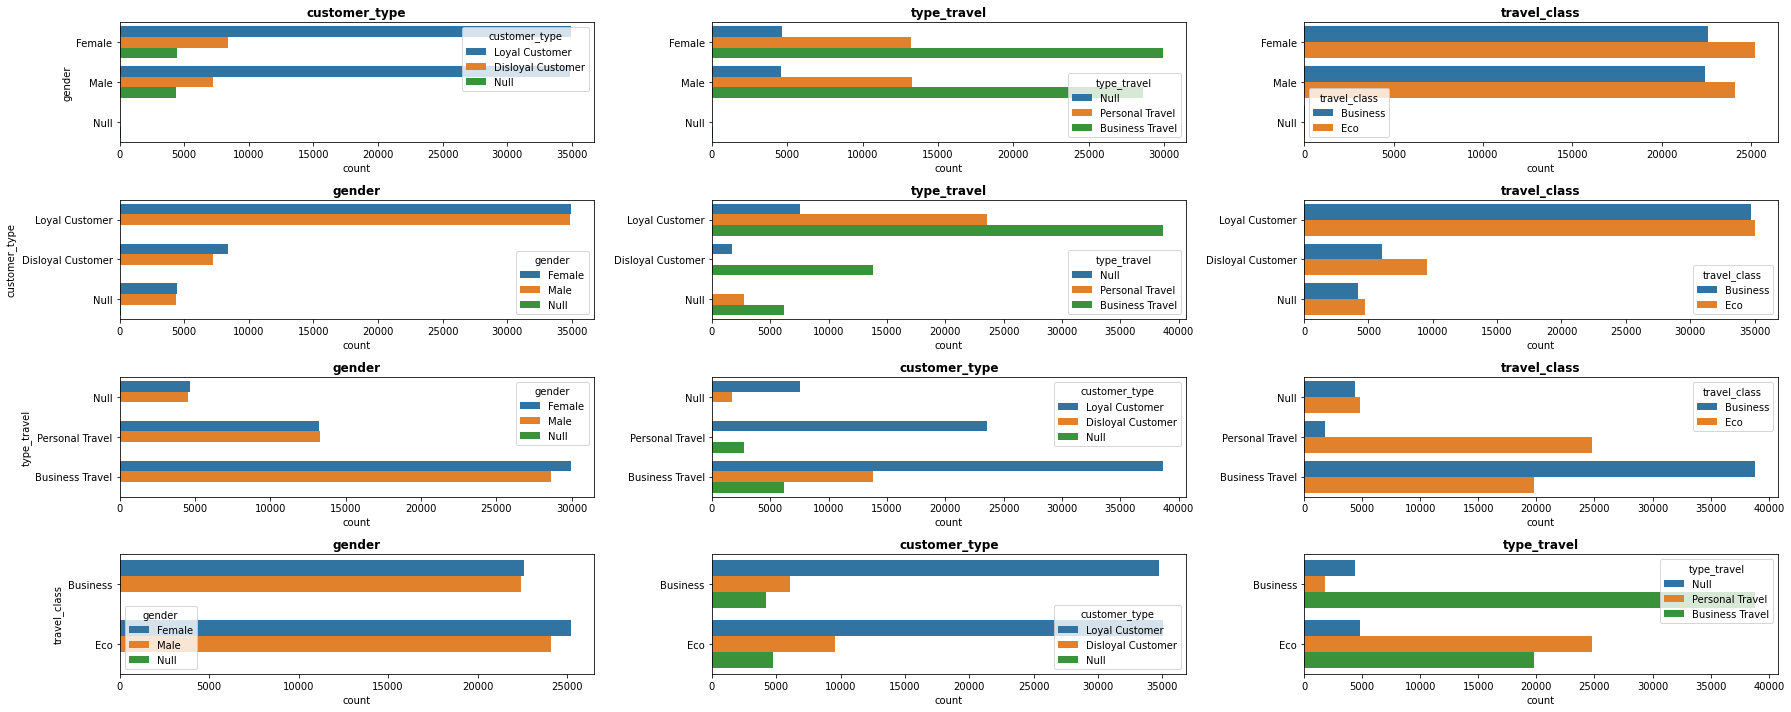

In [69]:
fig, ax = plt.subplots(4,3,figsize = (25,10));

ax_start = 0

for var in CAT_COL:  
  TEMP_LIST = CAT_COL.copy()
  TEMP_LIST.pop(TEMP_LIST.index(var))

  ax_end = ax_start+3

  for col, axs in zip(TEMP_LIST, ax.flatten()[ax_start:ax_end]):
    cnt = sns.countplot(
        data = plot_table, 
        y = var, 
        hue = col,
        ax = axs
        )
    
    if ax_start%3 == 0:
      cnt.set_ylabel(var)
    else:
      cnt.set_ylabel('')
    
    cnt.set_title(col, fontweight = 'bold')
    ax_start+=1

plt.tight_layout()

In [76]:
TEMP = train_travel[CAT_COL]

TEMP_TABLE = MultiColumnLabelEncoder(columns = CAT_COL).fit_transform(TEMP)

(<Figure size 1800x720 with 12 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f481d45f950>,
       dtype=object))

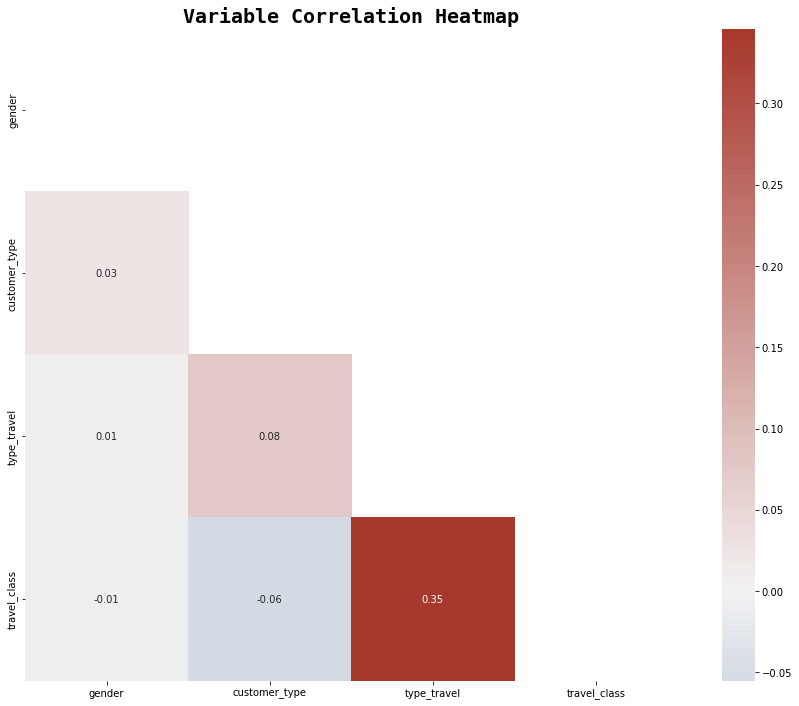

In [95]:
corr_heatmap(TEMP_TABLE)

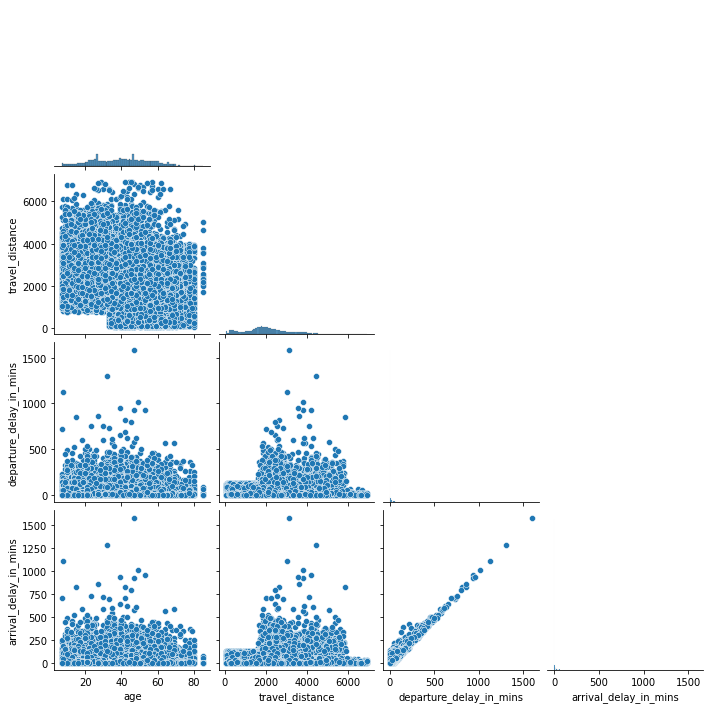

In [70]:
sns.pairplot(data = train_travel[NUM_COL], corner=True)

(<Figure size 1800x720 with 12 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f481d45f950>,
       dtype=object))

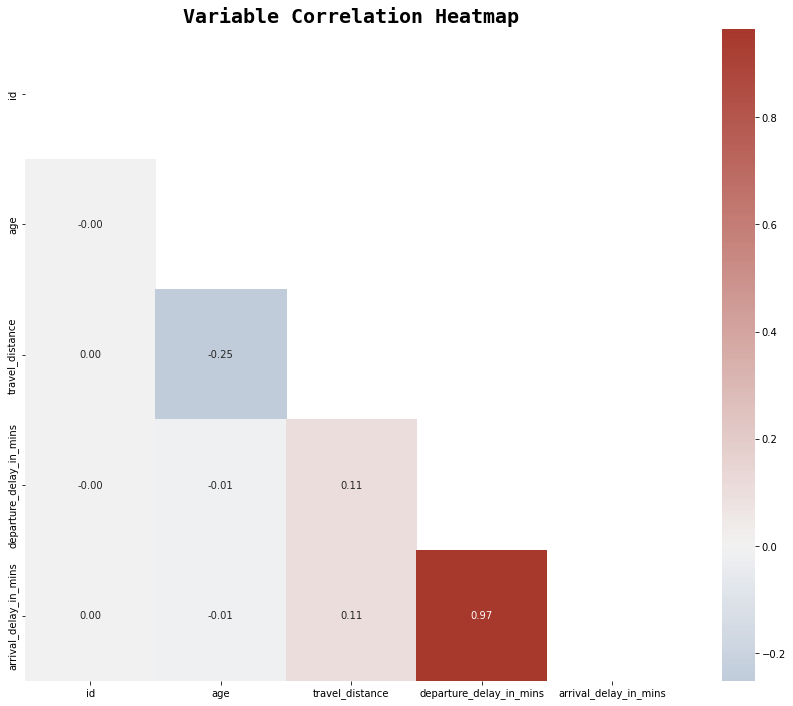

In [97]:
corr_heatmap(train_travel)

#### Observation

- Categorical
  - From the heatmap and the barplot, there are no strong correlation between categorical variables

- Numerical
  - From the heatmap and the pairplot, we see that departure and arrival delay have a strong correlation, almost completely linear with `0.97` correlation score.

## Survey

(<Figure size 1080x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f481dbc8190>)

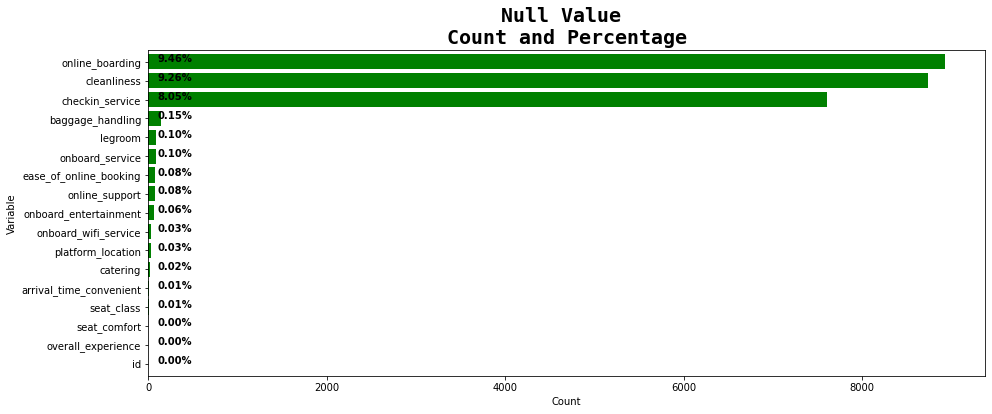

In [85]:
# check null value distribution
null_viz(train_survey)

(<Figure size 1440x1080 with 15 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4810684490>,
       dtype=object))

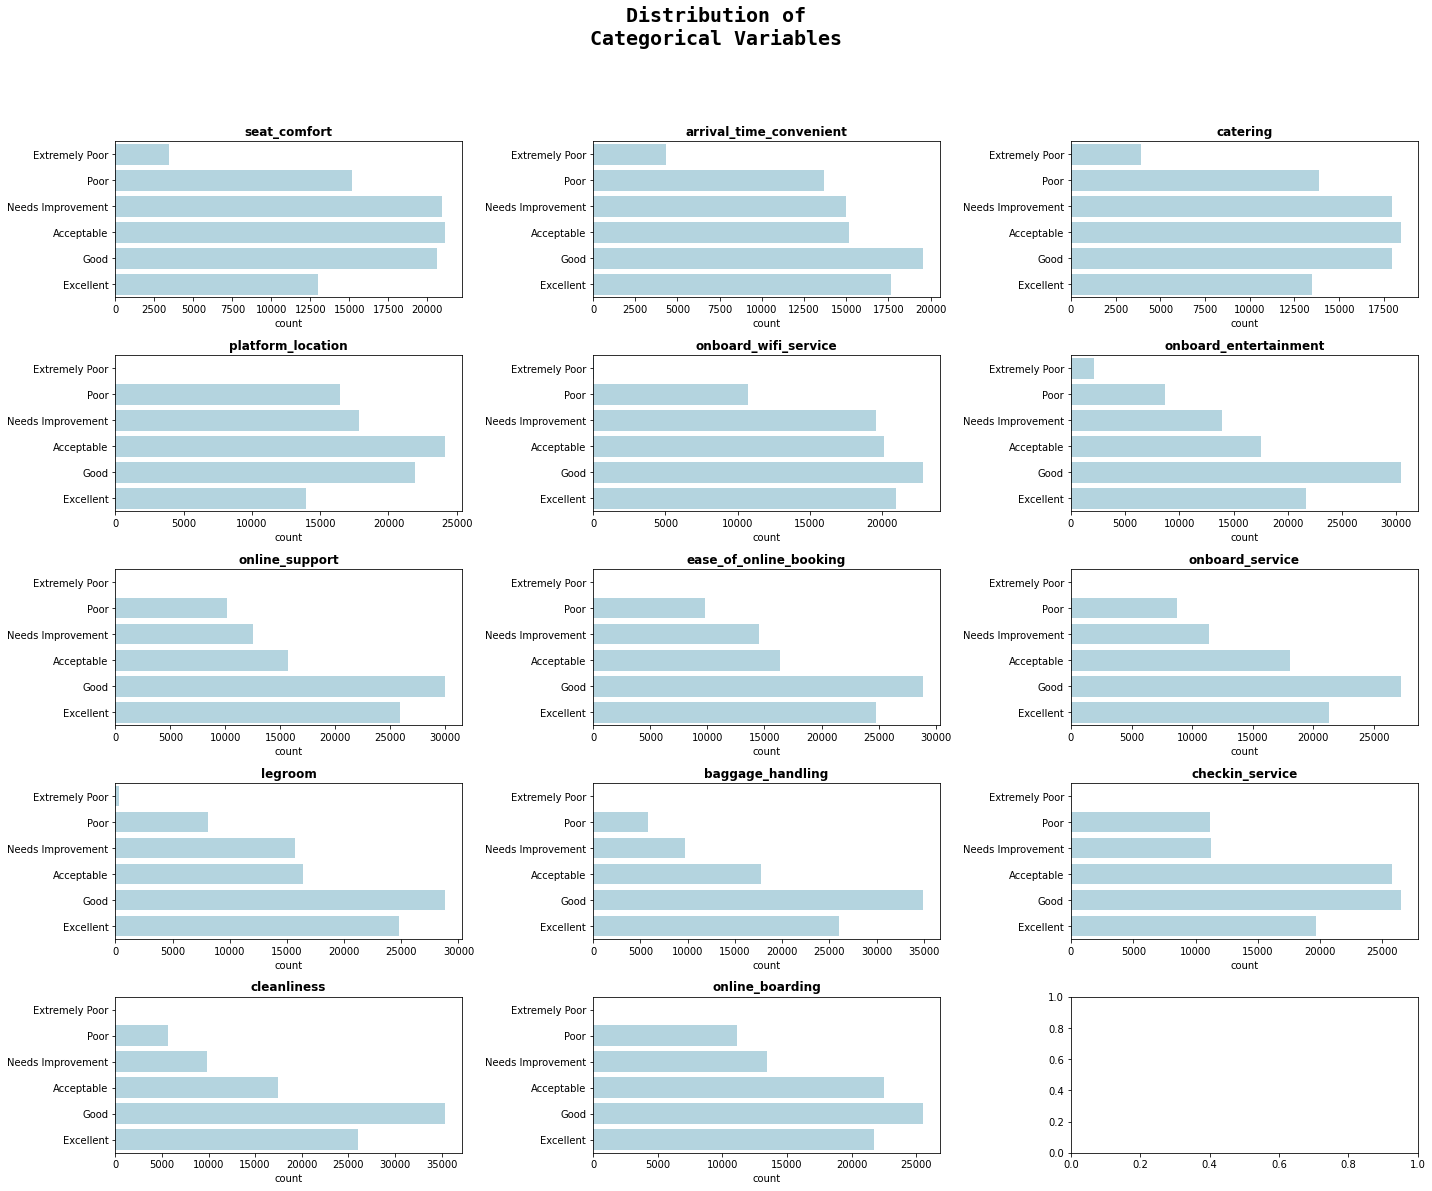

In [140]:
cat_distribution(data = train_survey.drop('seat_class', axis = 1), ncols=3, nrows=5, width = 20, height = 15, order = 'x')

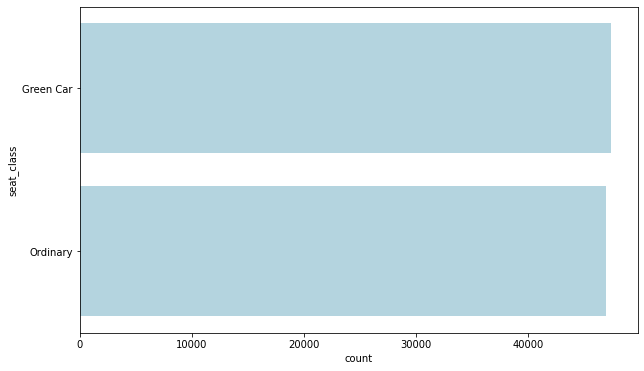

In [144]:
fig, ax = plt.subplots(figsize = (10,6))

sns.countplot(
    data = train_survey,
    y = 'seat_class',
    ax = ax,
    color = 'lightblue'
)

[Text(0, 0, 'Not satisfied'), Text(0, 0, 'Satisfied')]

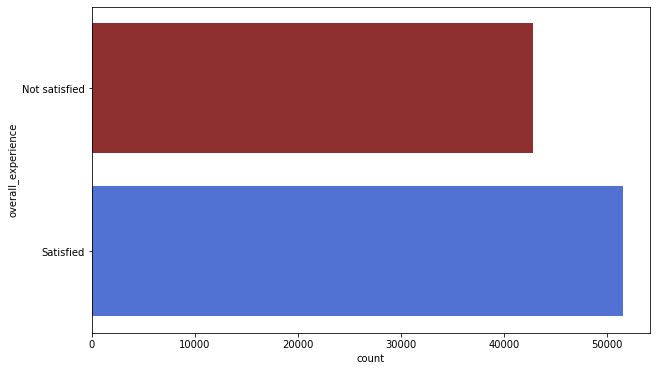

In [150]:
fig, ax = plt.subplots(figsize = (10,6))

sns.countplot(
    data = train_survey,
    y = 'overall_experience',
    ax = ax,
    palette=['#9e2020','#3c67e8'],
)

ax.set_yticklabels(['Not satisfied', 'Satisfied'])